In [1]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
import os
import sys
sys.path.append('C:/Users/w37262do/Documents/git/PyIR/src')
import spectral_preprocessing as sp
from matplotlib import pyplot as plt

In [2]:
def load_from_master(sheet_name, merge_annotations=False):
    master = pd.read_excel(sheet_name)
    he_filepaths = master['segmented HE filepath'].to_numpy()
    hdf5_filepaths = master['hdf5_filepaths'].to_numpy()

    t_or_n = master['T or N'].to_numpy()
    slides = master['Slide'].to_numpy()
    p_ids = master['Patient ID'].to_numpy()
    c_ids = master['Core Id'].to_numpy()

    path_infos = master['path_info'].to_numpy().astype(str)
    path_prepend = r'C:/Users/w37262do/Datasets/pcuk_2023/H_E_segmented'
    path_prepend_mask = r'C:/Users/w37262do/Datasets/pcuk_2023/H_E_segmented_tissuemasks'
    path_prepend_hdf5 = r'D:/workspace/code/PcrUK/PcrUK/HDF5 Data 3D'

    he_filepaths = np.array(
            [f"{path_prepend}/Slide {slides[x]}/" + he_filepath.split("/")[-1]
             for x,he_filepath in enumerate(he_filepaths)])
    mask_filepaths = np.array(
            [f"{path_prepend_mask}/Slide {slides[x]}/" + he_filepath.split("/")[-1]
             for x,he_filepath in enumerate(he_filepaths)])
    hdf5_filepaths = np.array([path_prepend_hdf5 + path.split('HDF5 Data')[-1] for path in hdf5_filepaths])
    hdf5_filepaths = np.array(
        [path.replace('D:/workspace/code/PcrUK/PcrUK', 'C:/Users/w37262do/Datasets/pcuk_2023').replace('DataCube/', '')
         for path in hdf5_filepaths])

    if not merge_annotations:
        return he_filepaths,hdf5_filepaths,mask_filepaths,t_or_n,slides,p_ids,c_ids,path_infos
    else:

        indexes = []
        indexes_keep = []
        annot_filepaths = []
        ## Load in the annotation files
        for s in list(set(slides)):
            annot_root = f'E:/workspace/code/PcrUK/PcrUK/annotations/Slide {s}/'
            for path in os.listdir(annot_root):
                if 'annotation' not in path: continue
                core_id = path.split('annotations')[0].split(' ')[-2]
                i = np.where(np.logical_and(slides == int(s), c_ids == int(core_id)))[0]
                if len(i) != 1: continue;
                indexes.append(i[0])
                indexes_keep.append(i[0])
                annot_filepaths.append(annot_root + path)

        ## Reconcile differenes between master and annotations
        indexes = np.array(indexes)
        he_filepaths = he_filepaths[indexes]
        hdf5_filepaths = hdf5_filepaths[indexes]
        t_or_n = t_or_n[indexes]
        slides = slides[indexes]
        p_ids = p_ids[indexes]
        c_ids = c_ids[indexes]
        path_infos = path_infos[indexes]
        indexes = np.arange(0, len(he_filepaths))

        return he_filepaths, hdf5_filepaths, mask_filepaths, t_or_n, slides, p_ids, c_ids, path_infos, annot_filepaths, indexes
    
def process_core_from_path(filepath,transform):
    core = h5py.File(filepath)['data/intensities'][:]
    mask = h5py.File(filepath)['data/tissue_mask'][:]
    wavenumbers = h5py.File(filepath)['data/wavenumbers'][:]
    shape = np.array(core.shape[:-1])
    core = core.reshape(np.prod(shape),-1); mask = mask.flatten()
    core, wavenumbers, mask = transform(core, wavenumbers, mask)
    core = core.reshape(*shape,-1); mask = mask.reshape(*shape)
    return core,wavenumbers,mask,shape

In [3]:
target_width = target_height = tw = th = 256

sheet_path = r'../lbp_3d/data/master_linked.xlsx'
he_filepaths, hdf5_filepaths, mask_filepaths, t_or_n, slides, p_ids, c_ids, path_infos = load_from_master(sheet_path,merge_annotations=False)
print(f"Dataset size: {len(he_filepaths)} items")

# Define preprocessing transform
tclass = sp.TestForChemical(
    np.load("C:/Users/w37262do/Documents/git/csegnet_pcr/model/pre_dougal_mean.npy"),
    np.load("C:/Users/w37262do/Documents/git/csegnet_pcr/model/pre_dougal_loadings.npy")
)
transform = tclass.trans_func
print(f"Using transformation: {tclass.name}")
annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0],[0,255,255],[255,255,0],])#[127,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood',"crushed","immune_infiltrate"])#,

Dataset size: 1095 items
Using transformation: Dougal Transform 1


In [9]:
hdf5_filepaths[:100]

array(['C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c4_p49bT',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c70_p111cT',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c14_p114aN',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c23_p114aT',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c32_p114aT',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c74_p114aT',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c42_p145aN',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c52_p145aN',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c57_p145aN',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c10_p159aT',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c45_p159aT',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data 3D/Slide 2/c54_p159aN',
       'C:/Users/w37262do/Datasets/pcuk_2023/HDF5 Data

In [10]:
#print(f"Processing cores, on core: ",end="\r")
# get data from master sheet
core_idx = 9
#hdf5_path = hdf5_filepaths[core_idx].replace()
path = hdf5_filepaths[core_idx].split('/')[-2:]
hdf5_path = 'D:/PcrUK/HDF5 Data 3D/' + path[0] + "/DataCube/" + path[1]
print(f"Processing cores, on core: {core_idx+1}/{len(hdf5_filepaths)}, {hdf5_path.split('/')[-1]}",end="")

# Load data from disk
core,wavenumbers,mask,shape = process_core_from_path(hdf5_path,transform=transform)

Processing cores, on core: 10/1095, c10_p159aT

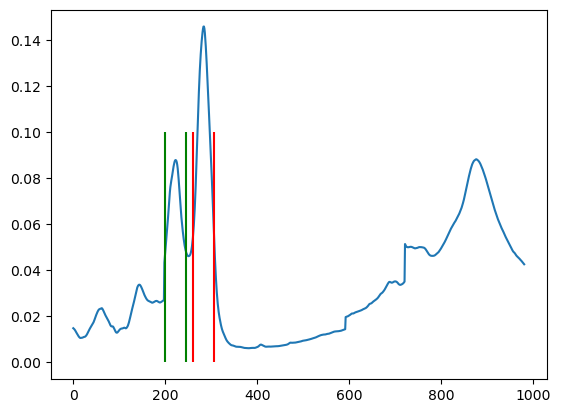

In [14]:
fig,ax = plt.subplots()
ax.plot(core.mean(axis=(0,1)))
ax.vlines(x=260,ymin=0,ymax=0.1,color='r')
ax.vlines(x=305,ymin=0,ymax=0.1,color='r')
ax.vlines(x=200,ymin=0,ymax=0.1,color='g')
ax.vlines(x=245,ymin=0,ymax=0.1,color='g')

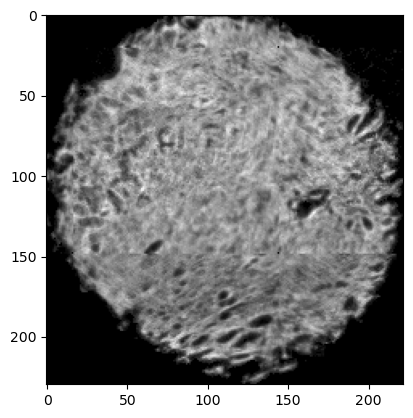

In [15]:
#show = core[:,:,265:305].sum(-1) - core[:,:,205:245].sum(-1)
show = core[:,:,260:306].sum(-1) - core[:,:,200:246].sum(-1)
show[show<0] = 0
show[show>13] = 13

fig,ax = plt.subplots()
ax.imshow(show,cmap='grey')